In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential, load_model
import mysql.connector
from keras.optimizers import Adam
from sklearn import preprocessing
cnx = mysql.connector.connect(user='root', password='941012',
                              host='127.0.0.1',
                              database='test0')
cursor = cnx.cursor()
query = ("SELECT n2,P1,T1,P2,T2 FROM test0.2016stablepoint LIMIT 1,20000")
cursor.execute(query)
result=cursor.fetchall()
x_list = np.array(result)
scaler = preprocessing.StandardScaler().fit(x_list)
train_x = scaler.transform(x_list)
#print train_x
query = ("SELECT P34 FROM test0.2016stablepoint LIMIT 1,20000")
cursor.execute(query)
result=cursor.fetchall()
y_list = np.array(result)
#print y_list
#print np.hstack((train_x,y_list))
x_list = np.hstack((train_x,y_list))
result = []
sequence_length = 20
for index in range(len(x_list) - sequence_length + 1):
    result.append(x_list[index: index + sequence_length])
result = np.array(result)
np.random.seed(10)
np.random.shuffle(result)
#print result
row = int(round(0.95 * result.shape[0]))
train = result[:row, :]
test = result[row:, :]
X_train = train[:,:,0:5]
y_train = train[:,-1, -1]
X_test = test[:,:,0:5]
y_test = test[:,-1, -1]
y_train = np.reshape(y_train, (y_train.shape[0],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))
#print X_train
#print y_train

Using TensorFlow backend.


In [2]:
BATCH_INDEX = 0
model = Sequential()
# RNN cell
layers = [5, 50, 100, 1]
model.add(LSTM(
        layers[1],
        input_shape=(sequence_length,layers[0]),
        return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
        layers[2],
        return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    layers[3]))
model.add(Activation("linear"))
    #model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
model.compile(loss="mse", optimizer="rmsprop", metrics=['mae', 'mape'])

cursor.close()
cnx.close()

#for step in range(1001):
    # data shape = (batch_num, steps, inputs/outputs)
#    X_batch = X_train[BATCH_INDEX: BATCH_INDEX+20, :, :]
#    Y_batch = y_train[BATCH_INDEX: BATCH_INDEX+20, :]
#    cost = model.train_on_batch(X_batch, Y_batch)
#    BATCH_INDEX += 20
#    BATCH_INDEX = 0 if BATCH_INDEX >= X_train.shape[0] else BATCH_INDEX

#    if step % 500 == 0:
#        cost, mae = model.evaluate(X_test, y_test, batch_size=y_test.shape[0], verbose=False)
#        print('test cost: ', cost, 'test accuracy: ', mae)

In [3]:
from keras.callbacks import TensorBoard
model.fit(
    X_train, y_train,
    batch_size=100, epochs=10,validation_split=0.05,callbacks=[TensorBoard(log_dir='./tmp/log')])

Train on 18032 samples, validate on 950 samples
Epoch 1/10
18032/18032 [==============================] - 7s 409us/step - loss: 710.1184 - mean_absolute_error: 25.7263 - mean_absolute_percentage_error: 54.8636 - val_loss: 276.2029 - val_mean_absolute_error: 16.4713 - val_mean_absolute_percentage_error: 35.0033
Epoch 2/10
18032/18032 [==============================] - 7s 367us/step - loss: 99.2980 - mean_absolute_error: 8.5576 - mean_absolute_percentage_error: 18.1214 - val_loss: 6.2044 - val_mean_absolute_error: 1.9850 - val_mean_absolute_percentage_error: 4.1295
Epoch 3/10
18032/18032 [==============================] - 7s 374us/step - loss: 8.0298 - mean_absolute_error: 2.1539 - mean_absolute_percentage_error: 4.5907 - val_loss: 0.2340 - val_mean_absolute_error: 0.3816 - val_mean_absolute_percentage_error: 0.8062
Epoch 4/10
18032/18032 [==============================] - 7s 377us/step - loss: 5.9366 - mean_absolute_error: 1.9369 - mean_absolute_percentage_error: 4.1366 - val_loss: 0.34

In [4]:
predicted = model.predict(X_test)
#print X_test
#print y_test

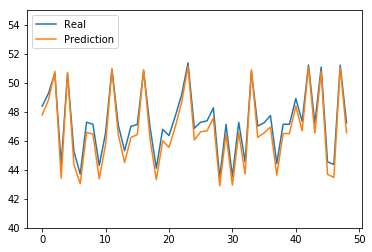

Accuracy:0.9847735898595522


In [5]:
predicted_pro = (np.mean(y_test)-np.mean(predicted))*np.ones(29)+predicted[1:30,0]
#print y_test[1:30]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y_test[1:50],label="Real")
ax.legend(loc='upper left')
plt.plot(predicted[1:50],label="Prediction")
plt.legend(loc='upper left')
plt.ylim(40,55)
plt.show()
acc = np.ones((y_test.shape[0],1))-abs((predicted-y_test)/y_test)
print 'Accuracy:'+str(np.mean(acc))
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)